In [ ]:
'''
序列数据，主要特征是顺序，其中隐藏很多的信息，包括模式、数据之间的关系等。
'''

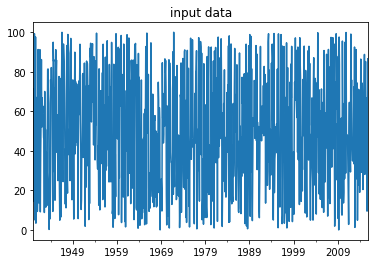

In [2]:
# -*- 将数据转换为时间序列格式 -*- #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def convert_data_to_timeseries(input_file, column, verbose=False):
    data = np.loadtxt(input_file, delimiter=',')
    
    # 提取日期做 X-axis ：有序时间序列的第一行与最后一行的第一、二列
    # -- 前后留空 --
    start_date = str(int(data[0,0])) + '-' + str(int(data[0,1]))
    end_date = str(int(data[-1,0] + 1)) + '-' + str(int(data[-1,1] % 12 + 1))

    # 创建以月为间隔的变量
    dates = pd.date_range(start_date, end_date, freq='M')
    
    # 将日期装换为时间序列
    data_timeseries = pd.Series(data[:,column], index=dates)
    
    # verbose
    if verbose :
        print('\nStart date =',start_date)
        print('\nEnd date =',end_date)
        print('\nTime Series data :',data_timeseries[:10])
    
    return data_timeseries

input_file = 'data_timeseries.txt'
column_num = 3
data_timeseries = convert_data_to_timeseries(input_file,column_num)

data_timeseries.plot()
plt.title("input data")
plt.show()

<class 'pandas.core.series.Series'>


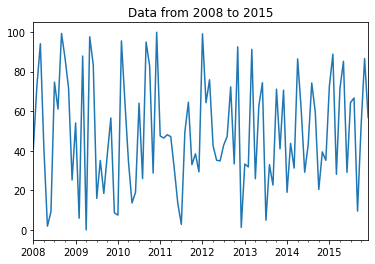

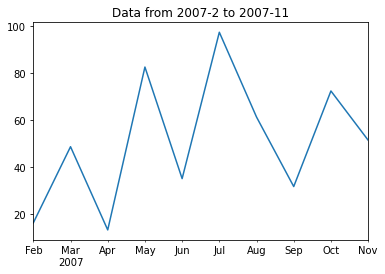

In [4]:
# -*- slice time-series data -*- #
print(type(data_timeseries)) # <class 'pandas.core.series.Series'>, ops similar list
start = '2008'
end = '2015'

plt.figure()
data_timeseries[start:end].plot()
plt.title("Data from "+ start + ' to ' + end)
plt.show()

start, end = '2007-2', '2007-11'
plt.figure()
data_timeseries[start:end].plot()
plt.title("Data from "+ start + ' to ' + end)
plt.show()

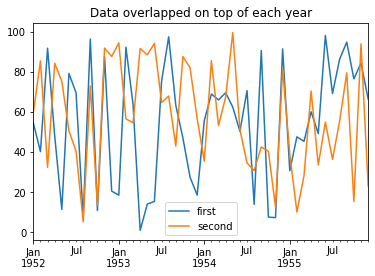

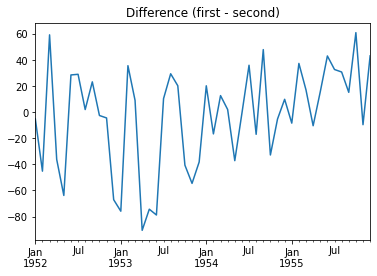

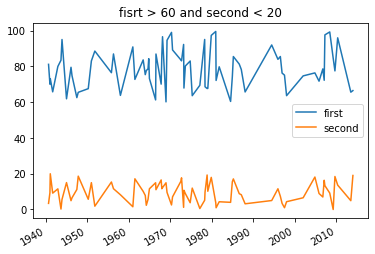

In [5]:
# -*- pandas 操作/过滤时间序列数据 -*- #
data1 = convert_data_to_timeseries(input_file,2) #取第三列
data2 = convert_data_to_timeseries(input_file,3) #取第四列

# dataset -> pandas data frame
dataframe = pd.DataFrame({'first':data1, 'second':data2})

dataframe['1952':'1955'].plot()
plt.title('Data overlapped on top of each year')

# 假定要画出在给定年份范围内，加载两份数据的不同
plt.figure()
difference = dataframe['1952':'1955']['first'] - dataframe['1952':'1955']['second']
difference.plot()
plt.title('Difference (first - second)')

# 用不同的条件分别过滤两组datasets
dataframe[(dataframe['first'] > 60) & (dataframe['second'] < 20)].plot()
plt.title('fisrt > 60 and second < 20')

plt.show()


Maximum:
 first     99.82
second    99.97
dtype: float64

Minimum:
 first     0.07
second    0.00
dtype: float64

Mean:
 first     51.264529
second    49.695417
dtype: float64

Mean row-wise:
 1940-01-31    81.885
1940-02-29    41.135
1940-03-31    10.305
1940-04-30    83.545
1940-05-31    18.395
1940-06-30    16.695
1940-07-31    86.875
1940-08-31    42.255
1940-09-30    55.880
1940-10-31    34.720
Freq: M, dtype: float64

Correlation coefficients:
            first    second
first   1.000000  0.077607
second  0.077607  1.000000


<Figure size 432x288 with 0 Axes>

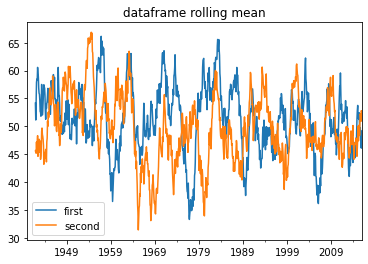

<Figure size 432x288 with 0 Axes>

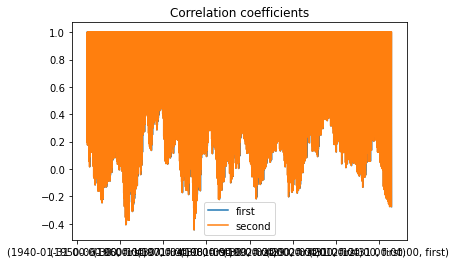

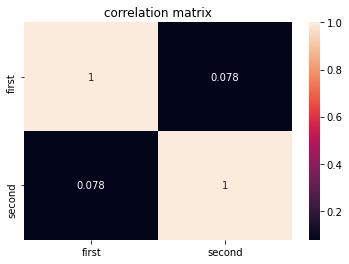

In [30]:
# -*- extract statistics from time-series datasets -*- #
print('\nMaximum:\n',dataframe.max())
print('\nMinimum:\n',dataframe.min())
print('\nMean:\n',dataframe.mean())
print('\nMean row-wise:\n',dataframe.mean(1)[:10]) # 行均值，区别mean(0)与mean(1)

# 滑动均值：计算一个活动窗口范围内的均值，平滑去噪
# pd.rolling_mean(dataframe, window=24).plot() -> function 已弃用
plt.figure()
dataframe.rolling(24).mean().plot()
plt.title('dataframe rolling mean')

# 相关性系数
print('\nCorrelation coefficients:\n',dataframe.corr())
#pd.rolling_corr(dataframe['first'], dataframe['second'], window=60).plot() -> function 已弃用
plt.figure()
dataframe.rolling(30).corr().plot()
plt.title("Correlation coefficients")

# 相关性矩阵
import seaborn as sn
plt.figure()
sn.heatmap(dataframe.corr(),annot=True)
plt.title('correlation matrix')

plt.show()

# 注意 plt.title() 的位置！

[[1.74e+03 1.00e+00 1.40e-01]
 [1.74e+03 2.00e+00 1.40e-01]
 [1.74e+03 3.00e+00 3.00e-02]
 [1.74e+03 4.00e+00 7.00e-02]
 [1.74e+03 5.00e+00 9.00e-02]] [[0.14]
 [0.14]
 [0.03]
 [0.07]
 [0.09]]

Training HMM ...
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_accumulate_sufficient_statistics', '_check', '_check_n_features', '_compute_log_likelihood', '_compute_posteriors', '_covars_', '_decode_map', '_decode_viterbi', '_do_backward_pass', '_do_forward_pass', '_do_mstep', '_do_viterbi_pass', '_generate_sample_from_state', '_get_n_fit_scalars_per_param', '_get_param_names', '_get_tags', '_init', '_initialize_sufficient_statistics', '_more_tags', '_needs_init', '_re

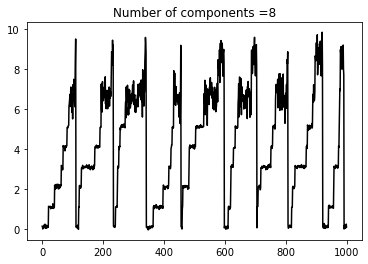

In [35]:
# -*- HMMs 隐马尔科夫模型 ：天气预报-*- #
'''
HMMs处理序列数据，广泛用于金融、语音分析、天气预测、单词序列等领域。
任何产生输入序列的数据源均可以产生模式，即HMMs是一个生成模型，可以根据底层结构生成数据：
HMMs不能对基础形式的类进行区分；反之，类区分的判定模型却不能生成数据
'''
import datetime
from hmmlearn.hmm import GaussianHMM

input_file = 'data_hmm.txt'
data = np.loadtxt(input_file, delimiter=',')

# 当有多列数据用于分析时，可以对数据进行堆叠
X = np.column_stack([data[:,2]])
print(data[:5],X[:5])

# 用4个成分创建并训练HMM，成分个数是一个超参
print("\nTraining HMM ...")
num_components = 8
model = GaussianHMM(n_components=num_components, covariance_type='diag',n_iter=1000)
model.fit(X)
print(dir(model))

# predict
hidden_states = model.predict(X)
print('\nModel and variance of hidden states:')
for i in range(model.n_components):
    print('\nHidden state ',i+1)
    print('Mean =',round(model.means_[i][0], 3))
    print('Variance =',round(np.diag(model.covars_[i])[0], 3))

# 用模型生成数据
num_samples = 1000
samples, _ = model.sample(num_samples)
plt.plot(np.arange(num_samples), samples[:,0], c='black')
plt.title("Number of components =" + str(num_components))
plt.show()

In [40]:
# -*- 条件随机场CRFs: 概率模型，标记和分析序列数据 -*- #
'''
HMMs生成模型 VS CRFs判定模型
HMMs: 定义对标签和观察序列的联合分布，并假设输出与观察值之间是独立的
CRFs: 给定带标签的观察序列，对其定义一个条件随机分布，输出与观察值之间的关系无碍
'''
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pystruct.datasets import load_letters
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

class CRFTrainer(object):
    def __init__(self, c_value, classifier_name='ChainCRF'):
        self.c_value = c_value
        self.classifier_name = classifier_name
        if self.classifier_name == 'ChainCRF':
            model = ChainCRF() # 链式随机场模型
            self.clf = FrankWolfeSSVM(model=model, C=self.c_value, max_iter=50) #SVM分类器
        else:
            raise TypeError('Invalid classifier type')
    
    def load_data(self):
        # 数据集中包括分割字母及其相关的特征向量，故不需分析图像
        letters = load_letters()
        X, y, folds = letters['data'], letters['labels'], letters['folds']
        X, y = np.array(X), np.array(y)
        
        return X, y, folds
    # X is a numpy array of samples , shape(n_letters, n_features)
    
    def train(self, X_train, y_train):
        self.clf(X_train, y_train)
        
    def evaluate(self, X_test, y_test):
        return self.clf.score(X_test, y_test)
    
    # 对输入数据运行分类器：预测
    def classify(self, input_data):
        return self.clf.predict(input_data)[0]

    
def decoder(arr):
    # 字母在变好的数组中被索引，解码使之可读
    alphabets = 'abcdefghijklmnopqrstuvwxyz'
    output = ''
    for i in arr:
        output += alphabets[i]
    return output

c_value = 8
crf = CRFTrainer(c_value)
X, y, folds = crf.load_data()
X_train, X_test = X[folds == 1], X[folds != 1]
y_train, y_test = y[folds == 1], y[folds != 1]

print('\nTraining the CRF model ...')
crf.train(X_train, y_train)

score = crf.evaluate(X_test, y_test)
print('\nAccuracy score =',str(round(score*100, 2)) + '%')

print('\nTrue label =',decoder(y_test[0]))
predicted_output = crf.classify(X_test[0])
print('\nPredicted output =',decoder(predicted_output))


ImportError: DLL load failed while importing base: 找不到指定的模块。